In [1]:
# import related librairies
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.estimator import DNNClassifier
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
import kerastuner
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import dataset
df = pd.read_csv('data/wine.csv', index_col=0)
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
index,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7


In [3]:
df.shape

(6497, 12)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 659.9 KB


In [6]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

<AxesSubplot:title={'center':'count'}>

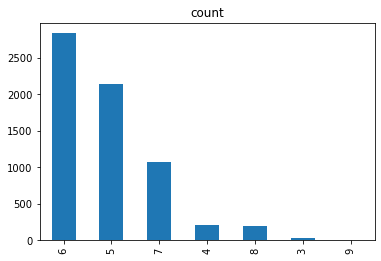

In [7]:
# plotting the labels
sample_count = df['quality'].value_counts()
sample_count.plot(kind='bar', title='count')

In [8]:
df1 = df.copy()

In [9]:
# rename the categories
df1['quality'].replace({3:0, 4:1, 5:2, 6:3, 7:4, 8:5, 9:6}, inplace=True)

In [10]:
y = df1[['quality']]
X = df1.drop('quality', axis=1)

In [43]:
# splitting train test
n_train = int(df.shape[0] * 0.3)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

In [44]:
# # resampling the train set 
# #smote = SMOTE(sampling_strategy='minority')
# ros = RandomOverSampler()
# X_train, y_train = ros.fit_resample(X_train, y_train)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1949, 11)
(4548, 11)
(1949, 1)
(4548, 1)


## Baseline

In [46]:
nb_hid_neur = 20
nb_features = X_train.shape[1]
nb_classes = len(pd.unique(df['quality']))

In [97]:
# setting up layers
from tensorflow import nn

model = Sequential([
    keras.layers.Flatten(),
    Dense(nb_hid_neur, activation='relu', input_dim=(nb_features)),
    Dense(512, activation= 'relu'),
    Dense(nb_hid_neur, activation= 'relu'),
    Dense(nb_classes, activation= 'sigmoid')
])

In [98]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss= 'sparse_categorical_crossentropy', #'mean_squared_error',
                metrics=['accuracy']
)

In [99]:
# changing type
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
#X_test = X_test.astype("float32")
#y_test = y_test.astype("float32")

In [100]:
# train the model
history = model.fit(X_train, y_train, verbose=False, epochs=80)
print("Finished training the model")

Finished training the model


In [101]:
model.build(input_shape=nb_features)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 11)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 20)                240       
_________________________________________________________________
dense_47 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_48 (Dense)             (None, 20)                10260     
_________________________________________________________________
dense_49 (Dense)             (None, 7)                 147       
Total params: 21,399
Trainable params: 21,399
Non-trainable params: 0
_________________________________________________________________


In [102]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [103]:
# attribut values
loss = history.history['loss']
accuracy = history.history['accuracy']

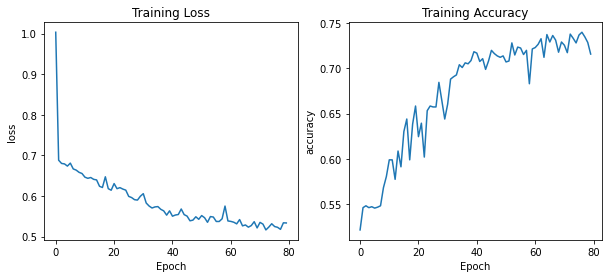

In [104]:
# plotting 
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set(xlabel='Epoch', ylabel='loss', title='Training Loss')
ax[0].plot(range(len(loss)), loss)
ax[1].plot(range(len(accuracy)), accuracy)
ax[1].set(xlabel='Epoch', ylabel='accuracy', title='Training Accuracy')
plt.show()

In [105]:
# predict the model
y_pred = model.predict(X_test)

In [106]:
# evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'\n Accuracy on test set is {test_accuracy * 100:.2f}%')
print(f'\n Loss on test set is {test_loss:.2f}%')


 Accuracy on test set is 69.09%

 Loss on test set is 0.59%


In [107]:
# evaluate the model train
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

print(f'\n Accuracy on train set is {train_accuracy * 100:.2f}%')
print(f'\n Loss on train set is {train_loss:.2f}')


 Accuracy on train set is 71.93%

 Loss on train set is 0.52


## Adjusting hyper parameters to perform the model

In [26]:
df2 = df.copy()

In [27]:
# rename the categories
# with 3 to 5 = medium(0), 6 to 8 = good(1) and 9 = very good (2)
df2['quality'].replace({3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:2}, inplace=True)

In [28]:
df2['quality'].unique()

array([0, 1, 2])

In [29]:
y = df2[['quality']]
X = df2.drop('quality', axis=1)

In [30]:
# splitting train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# resampling the train set 
#smote = SMOTE(sampling_strategy='minority') #, RandomOverSampler, 
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

<AxesSubplot:title={'center':'count'}, xlabel='quality'>

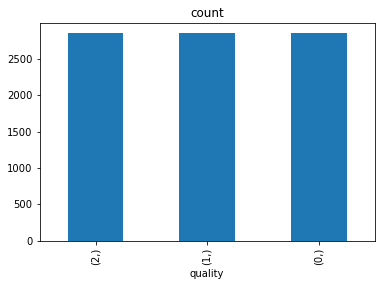

In [32]:
# plotting the labels
sample_count = y_train.value_counts()
sample_count.plot(kind='bar', title='count')

In [33]:
# function to normalize
def norm(x):
    mini = x.min()
    maxi = x.max()
    x = (x-mini)/(maxi-mini)
    return x

In [34]:
X_train.apply(norm)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.516949,0.273333,0.186992,0.027607,0.129568,0.123711,0.322485,0.148255,0.023622,0.125000,0.231405
1,0.330508,0.133333,0.284553,0.225460,0.078073,0.206186,0.328402,0.244650,0.417323,0.159091,0.264463
2,0.661017,0.263333,0.325203,0.012270,0.136213,0.034364,0.065089,0.191440,0.259843,0.244318,0.336088
3,0.330508,0.066667,0.276423,0.032209,0.094684,0.096220,0.153846,0.146327,0.496063,0.318182,0.628099
4,0.322034,0.113333,1.000000,0.061350,0.043189,0.343643,0.852071,0.059186,0.228346,0.119318,0.842975
...,...,...,...,...,...,...,...,...,...,...,...
8545,0.449153,0.126667,0.365854,0.153374,0.043189,0.185567,0.349112,0.190669,0.362205,0.136364,0.396694
8546,0.237288,0.186667,0.235772,0.015337,0.019934,0.158076,0.233728,0.048969,0.527559,0.221591,0.727273
8547,0.237288,0.186667,0.235772,0.015337,0.019934,0.158076,0.233728,0.048969,0.527559,0.221591,0.727273
8548,0.237288,0.186667,0.235772,0.015337,0.019934,0.158076,0.233728,0.048969,0.527559,0.221591,0.727273


In [35]:
X_train = X_train.astype(float)

In [36]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Dense(nb_hid_neur, activation='relu', input_shape=(nb_features,)))
              
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(tf.keras.layers.Dense(7, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='wineeessss')

INFO:tensorflow:Reloading Oracle from existing project my_dir/wineeessss/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/wineeessss/tuner0.json


In [38]:
tuner.search_space_summary()

In [39]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_split=0.2, verbose=False)

INFO:tensorflow:Oracle triggered exit


In [40]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]


In [41]:
# evaluate the model train
train_loss, train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)

print(f'\n Accuracy on train set is {train_accuracy * 100:.2f}%')
print(f'\n Loss on train set is {train_loss:.2f}')


 Accuracy on train set is 61.04%

 Loss on train set is 0.80


In [42]:
# Evaluate the best model.
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f'\n Accuracy on test set is {test_accuracy * 100:.2f}%')
print(f'\n Loss on test set is {test_loss:.2f}')


 Accuracy on test set is 31.90%

 Loss on test set is 0.99
